# pytorch 및 mask_rcnn 관련 import

In [1]:
import os

import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

import torch

import numpy as np

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data.transforms import build_transforms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list

# caffe glog 로깅 레벨 설정 및 caffe 및 tools 관련 import
os.environ['GLOG_minloglevel'] = '3'

# for model debugging log
from model_log import  logger

# DetectinDemo class 

In [2]:
# Detection V2 Model in PyTorch
class DetectionDemo(object):
    # --------------------------------
    # __init__(cfg, weight, is_recognition=False)
    # --------------------------------
    def __init__(self, cfg, weight, is_recognition=False):
        self.is_recognition = is_recognition
        self.cfg = cfg.clone()
        self.device = torch.device(cfg.MODEL.DEVICE)
        # self.device = torch.device("cpu")
        self.model = build_detection_model(self.cfg)
        self.model.to(self.device)

        # set to evaluation mode for interference
        self.model.eval()

        checkpointer = DetectronCheckpointer(cfg, self.model, save_dir='/dev/null')
        _ = checkpointer.load(weight)

        # build_transforms defined in maskrcnn_benchmark.data.transforms/*.py
        self.transforms = build_transforms(self.cfg, self.is_recognition)
        self.cpu_device = torch.device("cpu")
        self.score_thresh = self.cfg.TEST.SCORE_THRESHOLD

    # --------------------------------
    # run_on_pil(image_origin)
    # --------------------------------
    def run_on_pil_image(self, image_origin):
        # pil_image defined in __main__
        # call detection/recognition mode with PIL image
        prediction = self.compute_prediction(pil_image)

        prediction = self.filter_by_score(prediction)

        # prediction result (bbox) adjust to fit original image size
        prediction = prediction.resize(image_origin.size)
        result = self.parse_result(prediction)
        return result

    # --------------------------------
    # compute_predicion(image)
    # --------------------------------
    def compute_prediction(self, image):

        # input image transformation
        # - resize: using get_size() calc the image resize so as to use input to model
        # - to_tensor: image to tensonr( numpy.ndarray)
        # - normalization: RGB to GBR color channel ordering
        #       multiply 255 on pixel value
        #       normalization with constant mean and constant std defined in cfg
        logger.debug(f"compute_prediction(self, image)")
        logger.debug(f"\n\timage: H, W=({image.height},{image.width})")
        logger.debug(f"\n\timage_tensor = self.transforms(image)")

        image_tensor = self.transforms(image)

        import numpy as np
        np.save("./transformed_tensor.npy", image_tensor)

        logger.debug(f"\n\timage_tensor.shape: {image_tensor.shape}")


        # padding image for 32 divisible size on width and height
        logger.debug(f"\n\tpadding images for 32 divisible size on width and height")
        logger.debug(f"\timage_list = to_image_list(image_tensor, {self.cfg.DATALOADER.SIZE_DIVISIBILITY}).to(self.device)")

        image_list = to_image_list(image_tensor, self.cfg.DATALOADER.SIZE_DIVISIBILITY).to(self.device)

        np.save("./padded_tensor.npy", image_list.tensors.cpu())

        logger.debug(f"\timage_list.image_sizes: {image_list.image_sizes}")
        logger.debug(f"\timage_list.tensors.shape: {image_list.tensors.shape}")

        torch.save(self.model, "./detection_model_v2.pth")
        torch.save(self.model.backbone, "./detection_model_v2_backbone.pth")
        torch.save(self.model.backbone.body, "./detection_model_v2_backbone_body.pth")
        torch.save(self.model.backbone.fpn, "./detection_model_v2_backbone_fpn.pth")

        with torch.no_grad():
            logger.debug(f"\tpred = self.model(image_list)")
            pred = self.model(image_list)
            pred = pred[0].to(self.cpu_device)

        """
        model_param_dict = dict(self.model.named_parameters())
        logger.debug("-"*80)

        for key, value in model_param_dict.items():
            logger.debug(key)
            logger.debug(value)
            logger.debug("-"*80)
        """

        # make_dot(self.model(image_list), params=model_param_dict).render(f"detection_model_{version}", format="png")
        # https: // github.com / szagoruyko / pytorchviz / blob / master / examples.ipynb
        """
        with torch.onnx.set_training(self.model.backbone, False):
            trace, _ = torch.jit._get_trace_graph(self.model, args(image_list))
        make_dot_from_trace(trace).render(f"detection_mode_{version}_structure", format="png")
        """
        return pred
    
    # --------------------------------
    # filter_by_score(predition)
    # --------------------------------
    def filter_by_score(self, prediction):
        filter_thres = prediction.get_field('scores') > self.score_thresh
        return prediction[filter_thres]

    # --------------------------------
    # parse_result(pred)
    # --------------------------------
    def parse_result(self, pred):
        bbox = pred.bbox.numpy().tolist()
        scores = pred.get_field('scores').numpy().tolist()
        # labels = pred.get_field('labels').numpy().tolist()
        return dict(
            bboxes=bbox,  # list of [x1, y1, x2, y2]
            # labels=labels,  # no interest on label
            scores=scores,
        )


# Configuration File and Weigth File

In [3]:
detect_model = {
    "v1":
        {
            "config_file": "config_det_v1_200723_001_180k.yaml",
            "weight_file": "model_det_v1_200723_001_180k.pth"

        },
    "v2":
        {
            "config_file": "config_det_v2_200924_002_180k.yaml",
            "weight_file": "model_det_v2_200924_002_180k.pth"
        }
}


# Utility for drawin BBox visualization

In [4]:
def bb_image_draw(pil_image, line_color=(0, 0, 255), line_width=4, score_threshold=0.5):
    pil_image_cp = pil_image.copy()

    # for drawing bbox
    draw = ImageDraw.Draw(pil_image_cp)

    num_bbox_included = 0

    for idx, bbox in enumerate(bboxes):
        if scores[idx] > score_threshold:
            num_bbox_included += 1

            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = round(x1), round(y1), round(x2), round(y2)

            draw.rectangle(((x1, y1), (x2, y2)), outline=line_color, width=line_width)

    return pil_image_cp, num_bbox_included


/home/kimkk/miniconda3/envs/lomin/lib/python3.6/site-packages/torch/jit/__init__.py:1044: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[0, 719, 27, 57] (0.06862227618694305 vs. 0.06861035525798798) and 1 other locations (0.00%)
  check_tolerance, _force_outplace, True, _module_class)


graph(%self.1 : __torch__.torch.nn.modules.module.___torch_mangle_144.Module,
      %input.1 : Float(1, 3, 480, 576)):
  %3544 : __torch__.torch.nn.modules.module.___torch_mangle_143.Module = prim::GetAttr[name="fpn"](%self.1)
  %3518 : __torch__.torch.nn.modules.module.___torch_mangle_133.Module = prim::GetAttr[name="body"](%self.1)
  %3712 : __torch__.torch.nn.modules.module.___torch_mangle_132.Module = prim::GetAttr[name="layer4"](%3518)
  %3713 : __torch__.torch.nn.modules.module.___torch_mangle_107.Module = prim::GetAttr[name="layer3"](%3518)
  %3714 : __torch__.torch.nn.modules.module.___torch_mangle_61.Module = prim::GetAttr[name="layer2"](%3518)
  %3715 : __torch__.torch.nn.modules.module.___torch_mangle_29.Module = prim::GetAttr[name="layer1"](%3518)
  %3716 : __torch__.torch.nn.modules.module.___torch_mangle_4.Module = prim::GetAttr[name="stem"](%3518)
  %3717 : __torch__.torch.nn.modules.module.___torch_mangle_3.Module = prim::GetAttr[name="bn1"](%3716)
  %3718 : __torch__.t

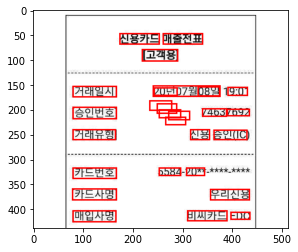

In [5]:
# model version
version = "v2"

# test image file path
image_file_path = "./sample_images/detection/1594202471809.jpg"
#image_file_path = "./sample_images/detection/1596537103856.jpeg"
#image_file_path = "./sample_images/video_frames/frame000000.png"

# set model conf file path and mode weight file path
# prefixed by ./model/[detection|recognition]
config_file = os.path.join('./model/detection', detect_model[version]["config_file"])
weight_file = os.path.join('./model/detection', detect_model[version]["weight_file"])

# clone project level config and merge with experiment config
cfg = cfg.clone()
cfg.merge_from_file(config_file)

# Detection model object creation
demo = DetectionDemo(cfg, weight_file)

# open image file as PIL.Image with RGB
pil_image = Image.open(image_file_path).convert('RGB')
org_pil_image = np.array(pil_image)
prediction = demo.run_on_pil_image(pil_image)


# draw with predicted boxes
bboxes = prediction['bboxes']
scores = prediction['scores']


bboxed_image, num_boxes = bb_image_draw(pil_image, line_color=(255, 0, 0), line_width = 3, score_threshold = 0.3)

# Display an image with Python
# https://stackoverflow.com/questions/35286540/display-an-image-with-python
plt.figure()
plt.imshow(bboxed_image)
plt.show()


# Model Inspection

In [6]:
print(demo.model)

GeneralizedRCNN(
  (backbone): Sequential(
    (body): ResNet(
      (stem): StemWithFixedBatchNorm(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
      )
      (layer1): Sequential(
        (0): BottleneckWithFixedBatchNorm(
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
        )
        (1): BottleneckWithFixedBatchNorm(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): Fro

----

## nn.Moduel.named_children()

```nn.Module.named_children()``` 메소드는 ```nn.Module``` 클래스 오브젝트의 ``immediate children object```(타입: nn.Module )의 name 스트링과  children object 자체로 구성된 튜플에 대한 **iterator**를 리턴
> (string, Module) – Tuple containing a name and child module

In [25]:
for name, module in demo.model.named_children():
    print(f"name: {name}")

name: backbone
name: rpn


In [8]:
print(demo.model.backbone)

Sequential(
  (body): ResNet(
    (stem): StemWithFixedBatchNorm(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
    )
    (layer1): Sequential(
      (0): BottleneckWithFixedBatchNorm(
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d()
        )
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d()
      )
      (1): BottleneckWithFixedBatchNorm(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stri

In [24]:
for name, module in demo.model.backbone.named_children():
    print(f"name: {name}")

name: body
name: fpn


In [26]:
for name, module in demo.model.backbone.body.named_children():
    print(f"name: {name}")

name: stem
name: layer1
name: layer2
name: layer3
name: layer4


In [27]:
for name, module in demo.model.backbone.body.stem.named_children():
    print(f"name: {name}")

name: conv1
name: bn1


In [28]:
print(demo.model.backbone.body.stem)

StemWithFixedBatchNorm(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): FrozenBatchNorm2d()
)


----

## nn.Module.named_parameters()

```nn.Module.named_parameters()``` 메소드는 ```nn.Module``` 클래스 오브젝트의 ```Parameter``` object( 타입: ```nn.Parameter```)의 name 스트링과  Parameter 오브젝트 자체로 구성된 튜플에 대한 **iterator**를 리턴
> (string, Parameter) – Tuple containing the name and parameter



### torch.nn.parameter.Parameter class

Tensor 의 일종으로 module parameter로 취급된다.
```Parameter``` 클래스 는 ```Tensor``` 클래스의 서브클래스로 ```nn.Module```클래스에서 사용되는 경우, 특별한 특성을 가진다. 
* ```Parameter```를 ```Module``` 의 속성(attributes)으로 할당되면 자동으로 ```Module`` 의 ```parameter``` 리스트에 추가되며,
* ```parameters()``` 메소드의 리턴값인 iterator를 통하여 표시된다.

일반 ```Tesnor``` 클래스는 위와 같은 특성을 가지지 않는다. 이는 모델에서 RNN의 마지막 hidden state와 같은 일부 temporary state를 캐쉬하기 위한 것이다. Parameter와 클래스가 없다면, 이들 임시 상태들도 등록되어야 한다.

```Parameters 클래스```는 다음과 같이 `data` 속성으로 `Tensor` 인스턴스를 포함하고, `requires_grad`라는 속성을 통하여, gradient 계산 기능이 추가된 것으로 이해할 수 있다.
* data (Tensor) – parameter tensor.
* **requires_grad** (bool, optional) – if the parameter requires gradient (Default: True). 

See [Locally disabling gradient computation](https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc) for more details. 

In [38]:
itr = demo.model.backbone.body.stem.named_parameters()  # get iterator
for name, param in itr:
    print(f"name: {name}")
    print(f"param.size: {param.size()}")
    

name: conv1.weight
param.size: torch.Size([64, 3, 7, 7])


In [42]:
itr = demo.model.named_parameters()  # get iterator
for name, param in itr:
    print(f"name: {name}")
    print(f"\tparam.size: {param.size()}\n")
    

name: backbone.body.stem.conv1.weight
	param.size: torch.Size([64, 3, 7, 7])

name: backbone.body.layer1.0.downsample.0.weight
	param.size: torch.Size([256, 64, 1, 1])

name: backbone.body.layer1.0.conv1.weight
	param.size: torch.Size([64, 64, 1, 1])

name: backbone.body.layer1.0.conv2.weight
	param.size: torch.Size([64, 64, 3, 3])

name: backbone.body.layer1.0.conv3.weight
	param.size: torch.Size([256, 64, 1, 1])

name: backbone.body.layer1.1.conv1.weight
	param.size: torch.Size([64, 256, 1, 1])

name: backbone.body.layer1.1.conv2.weight
	param.size: torch.Size([64, 64, 3, 3])

name: backbone.body.layer1.1.conv3.weight
	param.size: torch.Size([256, 64, 1, 1])

name: backbone.body.layer1.2.conv1.weight
	param.size: torch.Size([64, 256, 1, 1])

name: backbone.body.layer1.2.conv2.weight
	param.size: torch.Size([64, 64, 3, 3])

name: backbone.body.layer1.2.conv3.weight
	param.size: torch.Size([256, 64, 1, 1])

name: backbone.body.layer2.0.downsample.0.weight
	param.size: torch.Size([512, 

----

## named_buffers() vs buffers()
`nn.Module.named_buffers()` 메소드는 `nn.Module` 클래스 오브젝트의 `buffer`(타입: torch.Tensor)의 `name` 스트링과  `buffer` 오브젝트로 구성된 튜플에 대한 **iterator**를 리턴

* (string, torch.Tensor) – Tuple containing the name and buffer

`nn.Module.buffers()` 메소드는 `nn.Module` 클래스 오브젝트 의 buffer(타입: torch.Tensor)에 대한 iterator를 리턴
* torch.Tensor – module buffer

**Note**

Mask RCNN 소스상에서 FrozenBatchNormalization 레이어는 parameter값을 buffer 타입으로 저장하므로, `named_buffers()` 메소드를 호출하여 iterator를 구한후 다음과 같이 확인할 수 있다.

In [44]:
itr = demo.model.named_buffers()  # get iterator
for name, param in itr:
    print(f"name: {name}")
    print(f"\tsize: {param.size()}")

name: backbone.body.stem.bn1.weight
	size: torch.Size([64])
name: backbone.body.stem.bn1.bias
	size: torch.Size([64])
name: backbone.body.stem.bn1.running_mean
	size: torch.Size([64])
name: backbone.body.stem.bn1.running_var
	size: torch.Size([64])
name: backbone.body.layer1.0.downsample.1.weight
	size: torch.Size([256])
name: backbone.body.layer1.0.downsample.1.bias
	size: torch.Size([256])
name: backbone.body.layer1.0.downsample.1.running_mean
	size: torch.Size([256])
name: backbone.body.layer1.0.downsample.1.running_var
	size: torch.Size([256])
name: backbone.body.layer1.0.bn1.weight
	size: torch.Size([64])
name: backbone.body.layer1.0.bn1.bias
	size: torch.Size([64])
name: backbone.body.layer1.0.bn1.running_mean
	size: torch.Size([64])
name: backbone.body.layer1.0.bn1.running_var
	size: torch.Size([64])
name: backbone.body.layer1.0.bn2.weight
	size: torch.Size([64])
name: backbone.body.layer1.0.bn2.bias
	size: torch.Size([64])
name: backbone.body.layer1.0.bn2.running_mean
	size: to